# Data Simulation through Kriging

Author: Roe Djer (Roger) Tan <br>
email: roetan@okstate.edu

## Code General Description
This code generates a heatmap of pressure distribution on a seat caused by a person sitting on it, using the kriging method.

The code first generates a pressure map of the human body, which is an aggregation of two oval-shaped butt cheeks and two thigh areas, using the gaussian_filter function of the scipy.ndimage module. The pressure values are randomly generated within given ranges for the butt and thigh areas. The oval-shaped butt cheeks are defined using two covariance matrices, which are also randomly generated. The generated pressure map is then added to a randomly generated FSR (force-sensitive resistor) matrix, which represents the surface of the seat. The FSR matrix values are clipped to a given range and reduced for noise.

Then, a heatmap of the FSR matrix is created using the sns.heatmap function of the seaborn module, and it is saved to a file. The code then applies the kriging method on the FSR matrix to create a high-resolution pressure map. Finally, the code saves the resulting heatmap to another file.

The entire process is repeated multiple times in a loop, with different random values for the pressure and covariance matrices for each iteration, resulting in different pressure maps and FSR matrices for each iteration.

## Importing necessary library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom
import seaborn as sns
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import os
from PIL import Image

## Creating function
1. Generating a 100x100 simulated sensor matrix
2. Extract 10x10 from the matrix and apply kriging
3. Extract 5x5 from the matrix and apply kriging
4. Save the images

In [9]:
def kriging_heatmap_generation(i):
    ind=True
    while ind:
        # Define the dimensions of the FSR matrix
        n_rows = 100
        n_cols = 100

        # Define the range of possible FSR values
        fsr_range = (0, 1024)

        # Define the parameters of the pressure map
        pressure_sigma = 8

        # Define the weight distribution parameters for the human butt and thigh
        butt_pressure = np.random.randint(800,1200)
        thigh_pressure = np.random.randint(500,800)

        # Randomly define the centers of the two oval-shaped butt cheeks
        butt_center_x = np.random.randint(45, 65)
        butt_center_y = np.random.randint(45, 65)

        thigh_center_x = np.random.randint(40, 60)
        thigh_center_y = np.random.randint(5, 20)

        # Define the parameters of the two oval-shaped butt cheeks
        butt_cov1 = np.array([[8, 0], [0, 16]])
        butt_cov2 = np.array([[8, 0], [0, 16]])

        thigh_cov1 = np.array([[5, 0], [0, 10]])
        thigh_cov2 = np.array([[5, 0], [0, 10]])


        # Generate the heat maps for the two oval-shaped butt cheeks
        x, y = np.meshgrid(np.arange(n_cols), np.arange(n_rows))
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x
        pos[:, :, 1] = y
        butt_map1 = gaussian_filter(butt_pressure * np.exp(-0.5 * np.sum(np.square(np.dot(pos - [butt_center_x - np.random.randint(14,17), butt_center_y + np.random.choice([-1,1])*np.random.randint(0,2)], np.linalg.inv(butt_cov1))), axis=2)), sigma=pressure_sigma)
        butt_map2 = gaussian_filter(butt_pressure * np.exp(-0.5 * np.sum(np.square(np.dot(pos - [butt_center_x + np.random.randint(14,17), butt_center_y + np.random.choice([-1,1])*np.random.randint(0,2)], np.linalg.inv(butt_cov2))), axis=2)), sigma=pressure_sigma)
        thigh_map1 = gaussian_filter(thigh_pressure * np.exp(-0.5 * np.sum(np.square(np.dot(pos - [thigh_center_x - np.random.randint(23,26), thigh_center_y + np.random.choice([-1,1])*np.random.randint(0,2)], np.linalg.inv(thigh_cov1))), axis=2)), sigma=pressure_sigma)
        thigh_map2 = gaussian_filter(thigh_pressure * np.exp(-0.5 * np.sum(np.square(np.dot(pos - [thigh_center_x + np.random.randint(23,26), thigh_center_y + np.random.choice([-1,1])*np.random.randint(0,2)], np.linalg.inv(thigh_cov2))), axis=2)), sigma=pressure_sigma)

        # Combine the two oval-shaped butt cheeks
        body_map = butt_map1 + butt_map2 + thigh_map1 + thigh_map2

        # Add up the heat maps to get the overall pressure map of the human sitting on the seat
        pressure_map = body_map


        # Generate a random FSR matrix
        fsr_matrix = np.random.randint(0, 1, size=(n_rows, n_cols))

        # Add the pressure map to the FSR matrix
        fsr_matrix += pressure_map.astype(int)

        # Clip the FSR values to the allowed range
        fsr_matrix = np.clip(fsr_matrix, fsr_range[0], fsr_range[1])

        # Reduce noise
        phi = lambda x: 0 if x <= 5 else x
        data_flatten = fsr_matrix.flatten()
        fsr_matrix = np.array(list(map(phi, data_flatten))).reshape(fsr_matrix.shape)

        # Create a heatmap of the FSR matrix
        # plt.imshow(fsr_matrix, cmap="coolwarm", vmin=fsr_range[0], vmax=fsr_range[1])
        plt.figure(figsize=(5,5))
        sns.heatmap(fsr_matrix, cmap="viridis", cbar=False, vmin=0, vmax=800)
        plt.axis('off')
        plt.margins(0,0)
        plt.savefig(f'real\\real_{i}.png', bbox_inches='tight')
        plt.close()
        # Add a colorbar to the plot
        # plt.colorbar()

        # Set the title of the plot

        fsr_matrix_10x10 = zoom(fsr_matrix, 0.1)

        # Make sure the values are integers
        fsr_matrix_10x10 = fsr_matrix_10x10.astype(int)

        # Define the range of possible FSR values
        fsr_range = (0, 1023)

        data_10x10 = fsr_matrix_10x10
        # Kriging High
        x = np.arange(100) % 10
        y = np.arange(0, 10, 1).repeat(10)
        phi = data_10x10.flatten()

        OK = OrdinaryKriging(
        x,
        y,
        phi,
        variogram_model="gaussian",
        verbose=True,
        enable_plotting=True,
        )
        gridx = np.arange(-0.5, 9.5, 0.1, dtype='float64')
        gridy = np.arange(-0.5, 9.5, 0.1, dtype='float64')

        zstar, ss = OK.execute("grid", gridx, gridy)

        # assume real_image and kriging_result are numpy arrays of the same size
        residuals = fsr_matrix - zstar
        squared_residuals = residuals ** 2
        mean_squared_residuals = np.mean(squared_residuals)
        rmse = np.sqrt(mean_squared_residuals)
        print(rmse)

        if rmse < 80:
            #kt.write_asc_grid(gridx, gridy, z, filename="output.asc")
            plt.figure(figsize=(5,5))
            cax = plt.imshow(zstar, extent=(-0.5, 9.5, -0.5, 9.5), origin='lower',  cmap='viridis',  interpolation='gaussian', vmin=0, vmax=800)
            plt.ylim(9.5, -0.5) # Invert y-axis
            plt.axis('off')
            plt.margins(0,0)
            plt.savefig(f'kriging_high\\hr_{i}.png', bbox_inches='tight')
            plt.close()

            # Kriging Low
            #r = [0,0,0,0,
            #    1,1,
            #    2,2,2,2,
            #    3,3,3,3,
            #    4,4,4,4,
            #    5,5,5,5,
            #    6,6,6,6,
            #    7,7,7,7,
            #    8,8,
            #    9,9,9,9]
            #c = [0,3,6,9,
            #    3,6,
            #    2,4,5,7,
            #    0,3,6,9,
            #    2,4,5,7,
            #    2,4,5,7,
            #    0,3,6,9,
            #    2,4,5,7,
            #    3,6,
            #    0,3,6,9
            #    ]
            r = [
                0,0,0,0,0,
                2,2,2,2,2,
                4,4,4,4,4,
                6,6,6,6,6,
                8,8,8,8,8]
            c = [0,2,4,6,8,
                1,3,5,7,9,
                0,2,4,6,8,
                1,3,5,7,9,
                0,2,4,6,8
                ]
            data_lrk = data_10x10[r,c]
            x = np.array(c)
            y = np.array(r)
            phi = data_lrk.flatten()

            OK = OrdinaryKriging(
            x,
            y,
            phi,
            variogram_model="gaussian",
            verbose=True,
            enable_plotting=True,
            )
            gridx = np.arange(-0.5, 9.5, 0.1, dtype='float64')
            gridy = np.arange(-0.5, 9.5, 0.1, dtype='float64')
            zstar2, ss = OK.execute("grid", gridx, gridy)

            # assume real_image and kriging_result are numpy arrays of the same size
            residuals = zstar2 - zstar
            squared_residuals = residuals ** 2
            mean_squared_residuals = np.mean(squared_residuals)
            rmse = np.sqrt(mean_squared_residuals)
            print(rmse)

            if rmse < 80:
                #kt.write_asc_grid(gridx, gridy, z, filename="output.asc")
                plt.figure(figsize=(5,5))
                cax = plt.imshow(zstar2, extent=(-0.5, 9.5, -0.5, 9.5), origin='lower',  cmap='viridis', interpolation='gaussian', vmin=0, vmax=800)
                plt.ylim(9.5, -0.5) # Invert y-axis
                plt.axis('off')
                plt.margins(0,0)
                plt.savefig(f'kriging_low\\lr_{i}.png', bbox_inches='tight')
                plt.close()
                ind=False
            else:
                os.remove(f'kriging_high\\hr_{i}.png')
            

## Executing the function in loop to generate sample dataset

In [ ]:
for i in range(5000):
    kriging_heatmap_generation(i)
    print(f"{i} images have completed!")

## Trimming the dataset to get same resolution

In [11]:
left = 10
top = 10
right = 395
bottom = 395

for i in range(5000):
    # Load the image
    filename = f"real/real_{i}.png"
    img = Image.open(filename)
    
    # Crop the image
    cropped_img = img.crop((left, top, right, bottom))
    
    # Save the cropped image
    cropped_filename = f"real/real_{i}.png"
    cropped_img.save(cropped_filename)

    img.close()
    cropped_img.close()
    
    # Load the image
    filename = f"kriging_high/hr_{i}.png"
    img = Image.open(filename)
    
    # Crop the image
    cropped_img = img.crop((left, top, right, bottom))
    
    # Save the cropped image
    cropped_filename = f"kriging_high/hr_{i}.png"
    cropped_img.save(cropped_filename)
    
    img.close()
    cropped_img.close()
    
    # Load the image
    filename = f"kriging_low/lr_{i}.png"
    img = Image.open(filename)
    
    # Crop the image
    cropped_img = img.crop((left, top, right, bottom))
    
    # Save the cropped image
    cropped_filename = f"kriging_low/lr_{i}.png"
    cropped_img.save(cropped_filename)
    
    img.close()
    cropped_img.close()

print("Done!")

Done!


# Getting colorbar

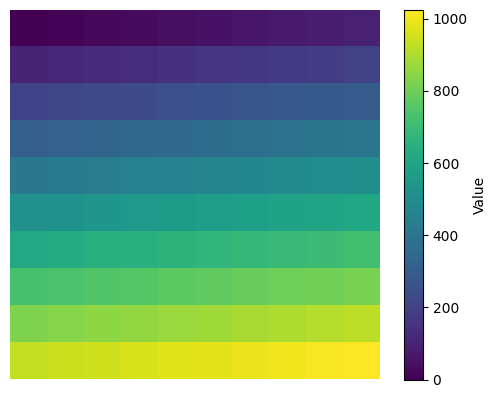

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create a dummy plot with a scalar colormap
dummy_data = np.linspace(0, 1024, 100).reshape(10, 10)
cax = plt.imshow(dummy_data, cmap='viridis')

# Create a color bar
cbar = plt.colorbar(cax)

# Set color bar label and range
cbar.set_label('Value')
#cbar.set_clim(0, 1024)

# Remove the unnecessary plot frame and axes
plt.axis('off')

# Show the color bar
plt.show()
